In [1]:
#Libraries

import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

In [2]:
#Data import

customers = pd.read_csv('olist_customers_dataset.csv') #dados clientes: id cliente,zip code, cidade, estado
orders = pd.read_csv('olist_orders_dataset.csv') #dados pedidos: id pedido, id cliente, status pedido, data pedido, data aprovação do pedido, data entrega transportadora, data entrega cliente
orders_items = pd.read_csv('olist_order_items_dataset.csv') #dados itens pedidos: id pedido, id item, id produto, id vendedor, data limite envio, preço, valor frete
products = pd.read_csv('olist_products_dataset.csv') #dados produtos: id produto, categoria produto, tamanho nome, tamanho descrição, fotos produtos, peso produto, medidas produto

In [3]:
#Data join

database = orders_items.merge(orders,on='order_id') #inclusão de id de cliente, status de pedidos a base de itens de pedidos
database = database.merge(customers, on = 'customer_id') #inclusão de detalhes de clientes a base de itens de pedidos
database = database.merge(products, on = 'product_id') #inclusão dados de produtos 

<AxesSubplot:xlabel='customer_state'>

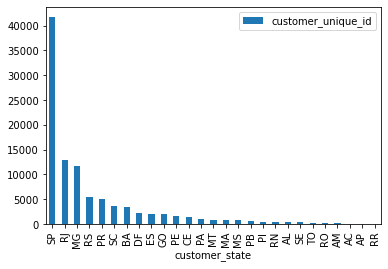

In [4]:
#Customers analysis
customers_df  = pd.DataFrame(customers.groupby('customer_state')['customer_unique_id'].count()) #análise por região
customers_df.sort_values(by='customer_unique_id', ascending= False, inplace=True)
customers_df.plot(kind= 'bar')

In [5]:
customers_spend = pd.DataFrame(database.groupby('customer_unique_id')['price'].sum()) #análise de gastos
customers_spend = customers_spend.reset_index()
customers_spend.sort_values(by='price', ascending = False, inplace=True)

In [6]:
#Análise de compras e período de compras por clientes
customer_time = []
customer_orders = []
customer_order = []

for customer in database['customer_unique_id']:
    filter_order = database[database['customer_unique_id'] == customer]
    first = filter_order['order_purchase_timestamp'].min()
    last = filter_order['order_purchase_timestamp'].max()
    order_count = filter_order['order_id'].nunique()

    
    customer_time.append([customer,first,last])
    customer_orders.append([customer,order_count])

In [7]:
customer_duration = pd.DataFrame(customer_time,columns=['customer_unique_id','first_purchase','last_purchase']) # dados de período de compras
customer_orders = pd.DataFrame(customer_orders,columns=['customer_unique_id','customer_orders']) # dados de volume de compras

In [8]:
#Customer database
customers_db = customers.copy()

customers_db = customers_db.merge(customer_duration,on='customer_unique_id') # inclusão de dados de primeira e última compra por cliente
customers_db = customers_db.merge(customer_orders,on='customer_unique_id') # inclusão de volume de compras por cliente
customers_db = customers_db.merge(customers_spend,on='customer_unique_id') # inclusão de total gasto em todas as compras por cliente

customers_db.drop_duplicates(subset='customer_unique_id',inplace=True) # remoção de valores duplicados por cliente

customers_db['first_purchase'] = pd.to_datetime(customers_db['first_purchase']) # transformação de formato de dado para datetime
customers_db['last_purchase'] = pd.to_datetime(customers_db['last_purchase']) # transformação de formato de dado para datetime
customers_db['time'] = customers_db['last_purchase'] - customers_db['first_purchase'] # cálculo do período entre primeira e última compra por cliente


In [9]:
# RFV analysis
customers_db.rename(columns={'price': 'valor',
                            'customer_orders':'frequência'},inplace = True) # renomeando coluna que contém a informação de total de valor gasto por cliente e orders por frequência
analysis_threshold = '30-09-2018' #data de simulação da análise RFV
analysis_date = datetime.strptime(analysis_threshold,'%d-%m-%Y')


#customers_db['recência'] = (customers_db['last_purchase'].max() - customers_db['last_purchase']).dt.days  #cálculo de recência; premissa de que análise foi feita no período da última compra realizada na plataforma
customers_db['recência'] = (analysis_date - customers_db['last_purchase']).dt.days  #cálculo de recência; premissa de que análise foi feita no período da última compra realizada na plataforma


In [10]:
# Análise descritiva base de clientes
customers_db[['frequência','recência','valor']].describe()

,frequência,recência,valor
count,95420.000000,95420.000000,95420.000000
mean,1.034018,269.501467,142.440198
std,0.211234,153.160846,217.656355
min,1.000000,26.000000,0.850000
25%,1.000000,145.000000,47.900000
50%,1.000000,250.000000,89.900000
75%,1.000000,379.000000,155.000000
max,16.000000,755.000000,13440.000000


In [11]:
#Model_database
df = customers_db[['frequência','recência','valor']] #segmentando variáveis

scaler = StandardScaler().fit(df)
df_scaled = scaler.transform(df)

df_scaled = pd.DataFrame(df_scaled, columns=df.columns[0:]) #df padronizada

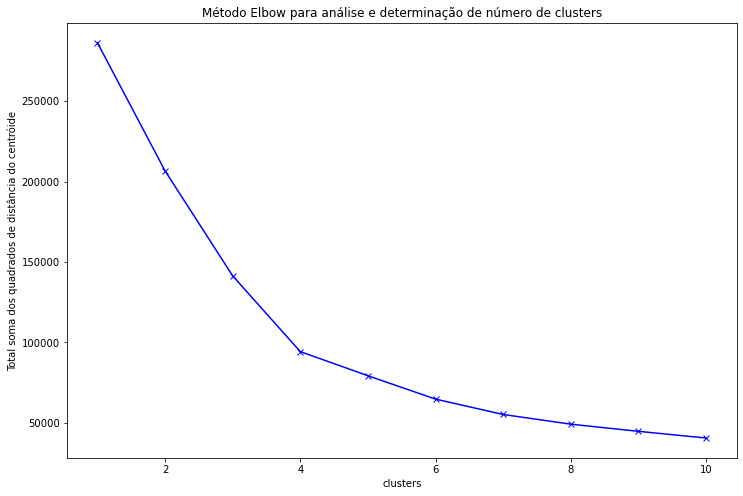

In [12]:
#Teste número de clusters
soma_quadrados = []
clusters = range(1,11)
for k in clusters:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df_scaled)
    soma_quadrados.append(kmeanModel.inertia_)

plt.figure(figsize=(12,8))
plt.plot(clusters, soma_quadrados, 'bx-')
plt.xlabel('clusters')
plt.ylabel('Total soma dos quadrados de distância do centróide')
plt.title('Método Elbow para análise e determinação de número de clusters')
plt.show()

In [13]:
#Clusterização com 4 clusters

kmeans = KMeans(n_clusters=4)
kmeans_fit = kmeans.fit_predict(df_scaled)

df['kmeans_4'] = kmeans.labels_

df.groupby('kmeans_4')[['frequência','recência','valor']].mean()

C:\Users\bruna\AppData\Local\Temp/ipykernel_20584/665214159.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['kmeans_4'] = kmeans.labels_


,frequência,recência,valor
kmeans_4,,,
0,1.000000,419.689429,114.546212
1,1.000000,159.493153,113.600586
2,2.114811,252.063476,243.049823
3,1.014109,270.192240,1146.407888


In [14]:
df.groupby('kmeans_4')['kmeans_4'].count()

kmeans_4
0    38352
1    51917
2     2883
3     2268
Name: kmeans_4, dtype: int64

In [15]:
df.groupby('kmeans_4')[['frequência','recência','valor']].median()

,frequência,recência,valor
kmeans_4,,,
0,1.0,407.0,82.99
1,1.0,161.0,84.90
2,2.0,231.0,179.97
3,1.0,254.0,912.00


In [ ]:
#Uso de dbscan

dbscan_method = DBSCAN(eps = 0.5, min_samples= 5).fit(df_scaled) #default
df['dbscan_default'] = dbscan_method.labels_

In [ ]:
df.groupby('dbscan_default')[['frequência','recência','valor']].mean()

In [ ]:
df.groupby('dbscan_default')['dbscan_default'].count()